# Assignment 1 - Deep Learning with Keras

This assignment will test you on the following skills: implementing a convolutional neural network in Keras, utilising the Functional Model API, building custom layers and loss functions, and analysing a trained model.

The model you will be building is called a Variational Autoencoder (VAE), a special type of neural network that uses Bayesian Inference to generate synthetic data. As described in the lectures, a VAE compresses a sample input into a low dimensional space (a latent vector). A constraint is applied in the form of a modification to the loss function, which has the effect of forcing the latent vector to look like a standard normal distribution.

This notebook is divided into sections, which you should use to complete the following tasks:

1. Implement a custom layer that performs the "reparameterization trick" described in the lectures.
2. Use the functional model API in keras to create an encoder model and a decoder model, using the specifications provided. Combine these models into the full VAE architecture.
3. Train the model using the celeb_a dataset of celebrity faces.
4. Create plots that demonstrate the ability of the network to reconstruct images, and generate new images.

In addition to submitting your completed notebook, you should write a 1-page report that discusses the results of the model.

In [ ]:
#pip install tensorflow-constrained-optimization

In [ ]:
#pip install tfx-bsl

In [ ]:
#@title Pip installs
### General Imports ###


In [1]:
# Module imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Input
from IPython import display
from tensorflow import keras

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

%matplotlib inline

# Task 1 - Reparameterisation layer

In [2]:
### Create a class called latent_sampling, which subclasses layers.Layer.
### The class should perform the reparameterisation trick in its .call()
### method.
### Reparameterization Trick: z = mean + epsilon * exp(ln(variance) * 0.5)
### epsilon = N(0,1), a unit normal with same dims as mean and variance


class latent_sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    mean, logvar = inputs
    #z = mean + epsilon * tf.math.exp(ln(tf.math.variance) * 0.5)
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    #epsilon = N(0,1)
    z = mean + K.exp(logvar / 2) * epsilon
    self.add_loss(-0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar)))
    self.add_metric(-0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar)), name='kl_loss')
    return z

# Include the follow two lines in your .call method:
# self.add_loss(-0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar)))
# self.add_metric(-0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar)), name='kl_loss')


# Task 2 - Model Definitions

In [3]:
### Create the encoder model, using the functional API and the architecture
### detailed below. Use tf.keras.models.Model to initialise the model.
# Ecoding

class encoder(layers.Layer):

    def __init__(self, latent_dim=32, intermediate_dim=64, name="encoder", **kwargs):
        super(encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.latent_sampling = latent_sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        mean = self.dense_mean(x)
        logvar = self.dense_log_var(x)
        z = self.latent_sampling((mean, logvar))
        return mean, logvar, z

# Model: "encoder"
# ____________________________________________________________________________________________________
#  Layer (type)            Output Shape           Activation  kernel_size  padding  Input
# ====================================================================================================
#  enc_input (InputLayer)  [(None, 128, 128, 3)]  None
#  enc_conv_1 (Conv2D)     (None, 64, 64, 32)     ReLU        (3,3)        'same'   enc_input
#  enc_conv_2 (Conv2D)     (None, 32, 32, 64)     ReLU        (3,3)        'same'   enc_conv_1
#  enc_conv_3 (Conv2D)     (None, 16, 16, 64)     ReLU        (3,3)        'same'   enc_conv_2    
#  enc_conv_4 (Conv2D)     (None, 8, 8, 64)       ReLU        (3,3)        'same'   enc_conv_3    
#  enc_flat (Flatten)      (None, 4096)           None        None         None     enc_conv_4
#  mean (Dense)          (None, 200)            None        None         None     enc_flat                        
#  logvar (Dense)       (None, 200)            None        None         None     enc_flat
#  z (latent_sampling)     (None, 200)            None        None         None     (mean, logvar)


In [4]:
### Create the decoder model, using the functional API and the architecture
### detailed below. Use tf.keras.models.Model to initialise the model.
# Decoding

class decoder(layers.Layer):

    def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super(decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)

# Model: "decoder"
# ____________________________________________________________________________________________________
#  Layer (type)                   Output Shape           Activation  kernel_size  padding  Input
# ====================================================================================================
#  dec_input (InputLayer)         [(None, 200)]          None
#  dec_dense (Dense)              (None, 4096)           ReLU        None         None     dec_input
#  dec_reshape (Reshape)          (None, 8, 8, 64)       None        None         None     dec_dense
#  dec_conv_1 (Conv2DTranspose)   (None, 8, 8, 64)       ReLU        (3,3)        'same'   dec_reshape
#  dec_conv_2 (Conv2DTranspose)   (None, 16, 16, 64)     ReLU        (3,3)        'same'   dec_conv_1
#  dec_conv_3 (Conv2DTranspose)   (None, 32, 32, 64)     ReLU        (3,3)        'same'   dec_conv_2    
#  dec_conv_4 (Conv2DTranspose)   (None, 64, 64, 32)     ReLU        (3,3)        'same'   dec_conv_3    
#  dec_output (Conv2DTranspose)   (None, 128, 128, 3)    ReLU        (3,3)        'same'   dec_conv_4


In [5]:
### Create the VAE model, again using tf.keras.models.Model, with the function
### API to combine the feed the outputs of the encoder into the inputs of the
### decoder.

class VariationalAutoencoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoencoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        mean, logvar, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            logvar - tf.square(mean) - tf.exp(logvar) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

# Task 3 - Train the model

In [6]:
# Provided here are the loss functions for the VAE model.

def recon_loss(y_true, y_pred):
    recon = tf.reduce_sum(tf.square(y_true-y_pred), axis=(1,2,3))
    return tf.reduce_mean(recon)

In [ ]:
#pip install tfds-nightly

In [ ]:
#pip install tensorflow-datasets

In [13]:
'''
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
#'''

Mounted at /content/drive


In [14]:
#!mkdir /content/celeba

In [ ]:
#!unzip /content/drive/MyDrive/img_align_celeba.zip -d /content/celeba

In [7]:
import pathlib
data_dir = pathlib.Path('/content/celeba/img_align_celeba')
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [128, 128])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = tf.cast(img, 'float32')/255.
  return img, img

proc_ds = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = proc_ds.take(20000).cache().batch(64, drop_remainder=True)
test_ds = proc_ds.take(10000).cache().batch(64, drop_remainder=True)

In [10]:
vae = VariationalAutoencoder(3, 128, 64)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)

vae.compile(optimizer, loss=recon_loss, metrics=['accuracy'])
model = vae.fit(train_ds, epochs=5, batch_size=7)

Epoch 1/5
312/312 [==============================] - 117s 359ms/step - loss: 149674.3594 - accuracy: 0.7326 - kl_loss: 136024.2812
Epoch 2/5
312/312 [==============================] - 91s 292ms/step - loss: 13674.6777 - accuracy: 0.7344 - kl_loss: 1.1335
Epoch 3/5
312/312 [==============================] - 94s 301ms/step - loss: 13674.6748 - accuracy: 0.7344 - kl_loss: 1.1244
Epoch 4/5
312/312 [==============================] - 92s 294ms/step - loss: 13674.5146 - accuracy: 0.7344 - kl_loss: 0.9668
Epoch 5/5
312/312 [==============================] - 90s 289ms/step - loss: 13675.8672 - accuracy: 0.7344 - kl_loss: 2.3193


# Task 4 - Analyse the Model

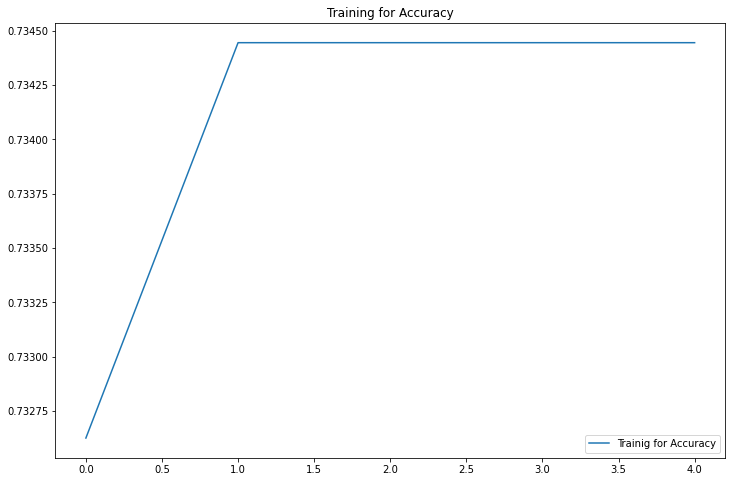

In [11]:
### Plot the losses and metrics. Comment on the figures in your report, with
### regard to how the training has proceeded.

train_accurate = model.history['accuracy']

epochs_range = range(5)

plt.figure(figsize=(12,8))
plt.plot(epochs_range, train_accurate, label='Trainig for Accuracy')
plt.legend(loc='lower right')
plt.title('Training for Accuracy')

plt.show()

<ipython-input-12-b4a51ff7a14b>:7: MatplotlibDeprecationWarning: Unrecognized location ' upper right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc=' upper right')


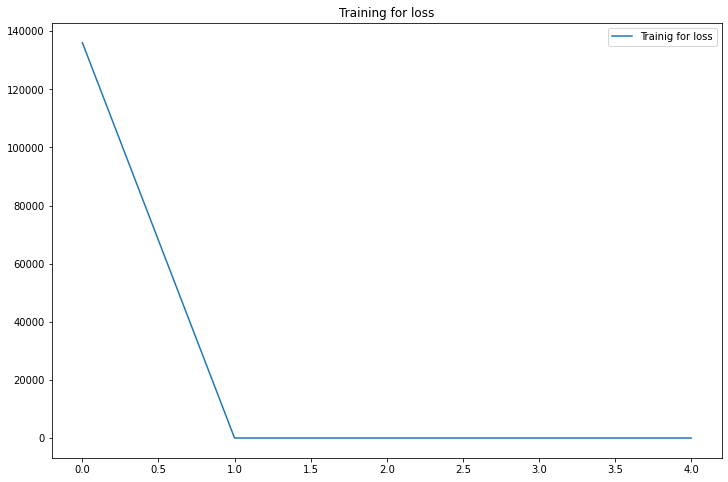

In [12]:
train_loss = model.history['kl_loss']

epochs_range = range(5)

plt.figure(figsize=(12,8))
plt.plot(epochs_range, train_loss, label='Trainig for loss')
plt.legend(loc=' upper right')
plt.title('Training for loss')

plt.show()

In [13]:
### Using the test dataset, create a plot that shows the reconstruction quality
### of the training model. Comment on the results in your report.

test_model = vae.fit(test_ds, epochs=5, batch_size=7)

Epoch 1/5
156/156 [==============================] - 45s 287ms/step - loss: 13691.8350 - accuracy: 0.7333 - kl_loss: 3.7200
Epoch 2/5
156/156 [==============================] - 45s 286ms/step - loss: 13738.1719 - accuracy: 0.7333 - kl_loss: 50.0587
Epoch 3/5
156/156 [==============================] - 45s 286ms/step - loss: 13717.5029 - accuracy: 0.7333 - kl_loss: 29.3876
Epoch 4/5
156/156 [==============================] - 45s 287ms/step - loss: 13696.0547 - accuracy: 0.7333 - kl_loss: 7.9357
Epoch 5/5
156/156 [==============================] - 45s 286ms/step - loss: 13695.4277 - accuracy: 0.7333 - kl_loss: 7.3113


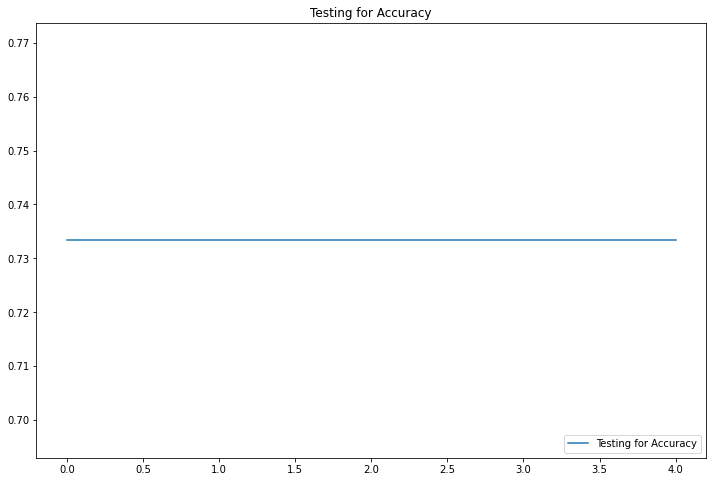

In [14]:
test_accurate = test_model.history['accuracy']

epochs_range = range(5)

plt.figure(figsize=(12,8))
plt.plot(epochs_range, test_accurate, label='Testing for Accuracy')
plt.legend(loc='lower right')
plt.title('Testing for Accuracy')

plt.show()

<ipython-input-15-b4344d5494ae>:8: MatplotlibDeprecationWarning: Unrecognized location ' upper right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc=' upper right')


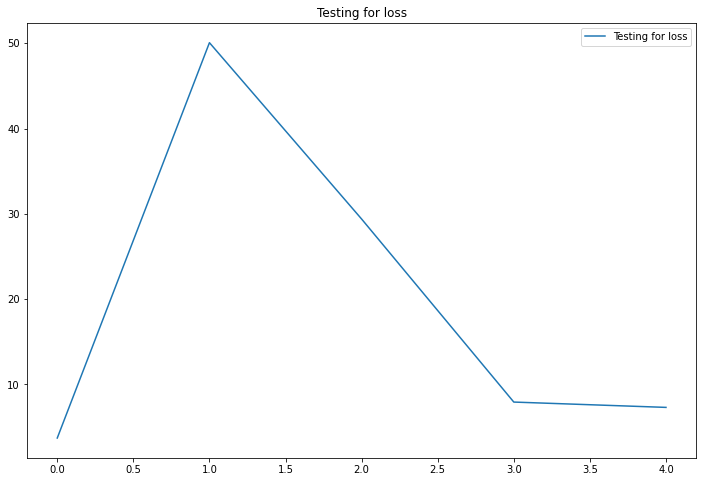

In [15]:
test_loss = test_model.history['kl_loss']


epochs_range = range(5)

plt.figure(figsize=(12,8))
plt.plot(epochs_range, test_loss, label='Testing for loss')
plt.legend(loc=' upper right')
plt.title('Testing for loss')

plt.show()

Real Test Images


TypeError: ignored

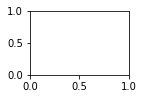

In [16]:
### Demonstrate the generative properties of the VAE by drawing randomly sampled
### latent vectors from a unit Guassian and passing them to the train decoder.
### Plot the results and comment on them in your report.


Reconstructed Images with Variational Autoencoder


TypeError: ignored

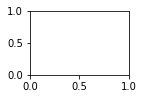

In [19]:
# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = vae.predict(np.array([train_ds[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()